In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter
import pickle
from scipy.signal import convolve

import matplotlib.colors as colors
import matplotlib.cm as cmx
import os
import sys

In [2]:
home = os.path.expanduser("~")
sys.path.insert(1, f'{home}/Documents/Repositories/motion_anticipation_network/model')
from utils import  DOG

# Speed scaling $V_{drive}$

In [53]:
def bar(t, xc, b = 0.160, v = 1):

    if xc >=-b+v*t and xc <=b+v*t :
        return 1
    else: 
        return 0
    

In [54]:
def biphasic_alpha(t,tauOPL,tauOPL2,SF):
    
    kern =  (t/tauOPL**2) * np.exp(-t/tauOPL) * np.heaviside(t,1) -  SF* (t/tauOPL2**2) * np.exp(-t/tauOPL2) * np.heaviside(t,1) 
    # kern = (t/tauOPL) * np.exp(-t/tauOPL) * np.heaviside(t,1) -  SF* (t/tauOPL2) * np.exp(-t/tauOPL2) * np.heaviside(t,1) 
    # kern = kern/(np.sum(kern)*0.001)
    #calculate integral
    return  kern


tauOPLmono = 0.04
tauOPL = 0.08
tauOPL2 = 0.0876
SF = 1.

ftime = np.arange(0,1,0.001)
filter_mono = biphasic_alpha(ftime,tauOPLmono,1,0)
filter_mono = filter_mono/filter_mono.max()
filter_bi = biphasic_alpha(ftime,tauOPL,tauOPL2,SF)
filter_bi = filter_bi/filter_bi.max()


In [55]:
speeds = np.asarray([0.1,0.2,0.3,0.4,0.4,0.5,0.6,0.7,0.8,0.9,1.0,2.0,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9])
speeds = speeds[::2]

In [63]:
data = {}
cell = 50


nets_list = ['fb_linear/wBA/wBA_0.0',
             'fb_linear/wBA/wBA_10.0',
             'ff_linear/wGA/wGA_0.04']
             

for net in nets_list:
    
    data[net] = {}

    bars = []
    tps_rf_GC_mid = []
    times = []

    Fs = []
    inps = []
    RBs = []
    RAs = []
    RGs = []

    peaks_RG = []
    peaks_RB = []
    peaks_RA = []
    peaks_drive = []

    amps_RB = []
    amps_RA = []
    amps_RG = []
    amps_drive = []
    amps_inp = []

    ants_RB_drive = []
    ants_RB_bar = []
    ants_RA_bar = []

    ants_RG_drive = []
    ants_RG_bar = []
    ants_drive = []

    for s in speeds: 
        fp = f'{home}/Documents/Simulations/motion_anticipation_network/{net}/smooth_{s}'
        with open(f'{fp}/out_smooth', 'rb') as handle:
            out = pickle.load(handle)    
            
        with open(f'{fp}/params', 'rb') as handle:
            paramsi = pickle.load(handle)
            
        duration = paramsi['duration']
        dt = paramsi['dt']
        time = np.arange(0,duration,dt) #- (paramsi['spacing']*cell)/paramsi['speed']#*1000#+45
        pos_cell = paramsi['pos_rf_GC_mid'][150]
        barr = [bar(t,pos_cell, v = s) for t in time]
        tp_bar = paramsi['tps_rf_GC_mid'][150]

        peak_RB = time[np.argmax(out['RB'][50,:])]
        peak_RA = time[np.argmax(out['RA'][50,:])]
        peak_RG = time[np.argmax(out['RG'][:])]
        peak_drive = time[np.argmax(out['F'][:])]

        amp_RB = np.max(out['RB'][50,:])
        amp_RA = np.max(out['RA'][50,:])
        amp_RG = np.max(out['RG'][:])
        amp_drive = np.max(out['F'][:])
        amp_inp = np.max(out['inp'][:])

        
        # RAM
        ant_RB_drive =  peak_drive - peak_RB
        ant_RB_bar  =  (tp_bar - peak_RB)*s
        ant_RA_bar  =  (tp_bar - peak_RA)*s

        ant_RG_drive =  peak_drive - peak_RG
        ant_RG_bar =  (tp_bar - peak_RG)*s
    
        ant_drive =  tp_bar - peak_drive

        bars.append(barr)
        tps_rf_GC_mid.append(tp_bar)
        times.append(time)

        Fs.append(out['F'])
        inps.append(out['inp'])
        RBs.append(out['RB'][50,:])
        RAs.append(out['RA'][50,:])
        RGs.append(out['RG'])

        peaks_RB.append(peak_RB)
        peaks_RA.append(peak_RA)
        peaks_RG.append(peak_RG)
        peaks_drive.append(peak_drive)

        amps_RB.append(amp_RB)
        amps_RA.append(amp_RA)
        amps_RG.append(amp_RG)
        amps_drive.append(amp_drive)
        amps_inp.append(amp_inp)

        ants_RB_drive.append(ant_RB_drive)
        ants_RB_bar.append(ant_RB_bar)
        ants_RA_bar.append(ant_RA_bar)
        
        ants_RG_drive.append(ant_RG_drive)
        ants_RG_bar.append(ant_RG_bar)
        ants_drive.append(ant_drive)


    
    data[net]['peaks']={}
    data[net]['peaks']['RB'] = np.asarray(peaks_RB)
    data[net]['peaks']['RA'] = np.asarray(peaks_RA)
    data[net]['peaks']['RG'] = np.asarray(peaks_RG)
    data[net]['peaks']['drive'] =np.asarray( peaks_drive)  

    data[net]['amps']={}
    data[net]['amps']['RB'] = np.asarray(amps_RB)
    data[net]['amps']['RA'] = np.asarray(amps_RA)
    data[net]['amps']['RG'] = np.asarray(amps_RG)
    data[net]['amps']['drive'] =np.asarray( amps_drive)
    data[net]['amps']['inp'] =np.asarray( amps_inp)

    data[net]['ants'] ={}
    data[net]['ants']['RB_drive'] =np.asarray(ants_RB_drive)
    data[net]['ants']['RB_bar'] =np.asarray(ants_RB_bar)
    data[net]['ants']['RA_bar'] =np.asarray(ants_RA_bar)
    data[net]['ants']['RG_drive'] =np.asarray(ants_RG_drive)
    data[net]['ants']['RG_bar'] =np.asarray(ants_RG_bar)
    data[net]['ants']['drive'] =np.asarray(ants_drive)
    
    data[net]['RB'] = RBs
    data[net]['RA'] = RAs
    data[net]['RG'] = RGs
    data[net]['F'] = Fs

    data[net]['input_scale'] = paramsi['input_scale']

    data['bars'] = bars
    data['tps_rf_mid'] = np.asarray(tps_rf_GC_mid)
    data['times'] = times

In [64]:
peak_RB

0.47000000000000003

In [65]:
def normalize(vals):
    vals = np.asarray(vals)
    return (vals-np.mean(vals))/np.std(vals)

In [66]:
net_b = nets_list[0]
net_fb = nets_list[1]
net_ff = nets_list[2]

In [67]:
speeds_plot = [0.1,0.5,1.0]
speeds_plot_idx = [0,4,-2]
xlims = [(2,12),(1.2,3),(0.2,0.75)]

# Figure Parameter

In [68]:
fontsize_legend = 15
fontsize_labels = 15
fontsize_panellabel = 30
fontsize_ticks = 10
lw = 4
ms = 60

figsize_ratio = 3
figsize = (22,12)

save = True
save_name = "Figure 1"
show = True
image_format = "png"
dpi = 300

panellabel_position = [-0.17, .8]

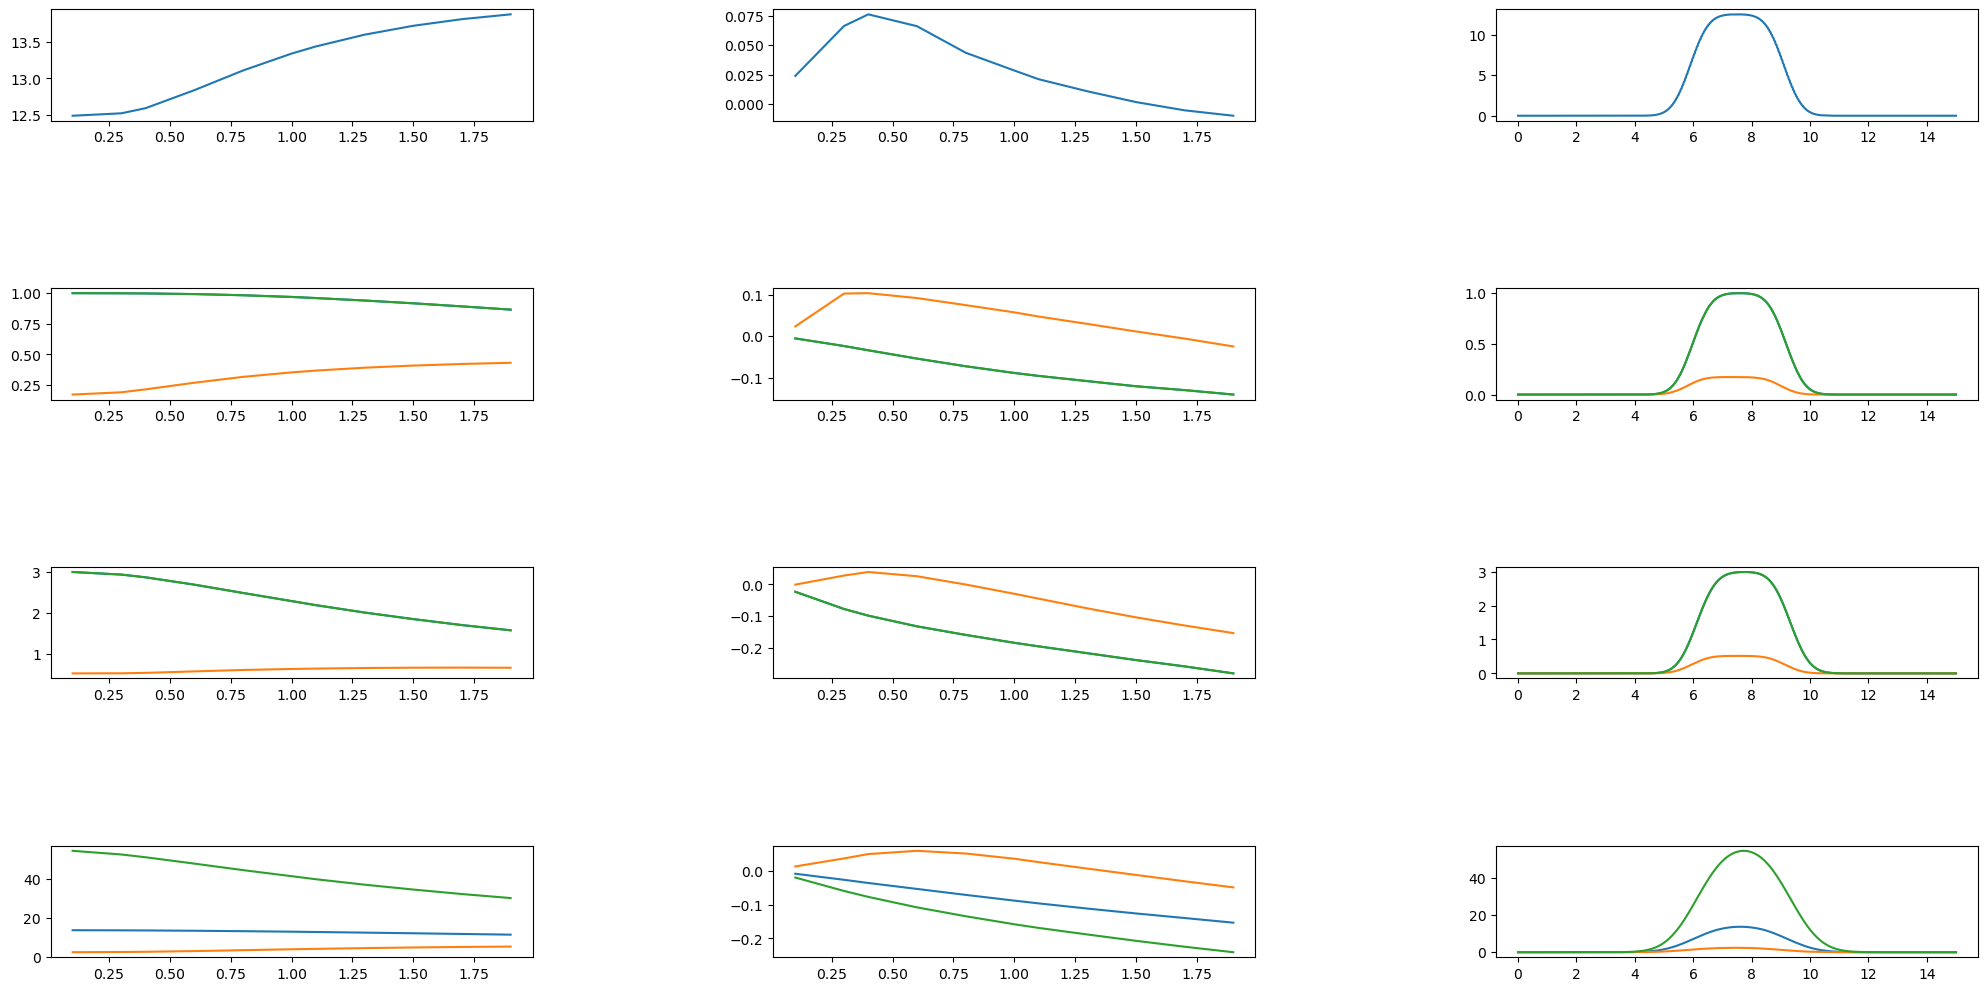

In [71]:
#initialize figure

nrows = 4
ncols = 3

fig = plt.figure(figsize=figsize)
#fig = plt.figure(figsize=(ncols*figsize_ratio,nrows*figsize_ratio))
fig.patch.set_facecolor('white')

gs = fig.add_gridspec(nrows,ncols)
#fig.tight_layout()



fig.subplots_adjust(top=0.892,
                        bottom=0.102,
                        left=0.068,
                        right=0.944,
                        hspace=1.5,
                        wspace=.5)
cbar = 'grey'
c1 = 'k'


 
# responses
axD = fig.add_subplot(gs[0,2])
axD.plot(data['times'][0],data[net_b]['F'][0], label = r'bipolar only' )



axB = fig.add_subplot(gs[1,2])
axB.plot(data['times'][0],data[net_b]['RB'][0], label = r'bipolar only' )
axB.plot(data['times'][0],data[net_fb]['RB'][0], label = r'feed-back' )
axB.plot(data['times'][0],data[net_ff]['RB'][0], label = r'feed-forward' )


axA = fig.add_subplot(gs[2,2])
axA.plot(data['times'][0],data[net_b]['RA'][0], label = r'bipolar only' )
axA.plot(data['times'][0],data[net_fb]['RA'][0], label = r'feed-back' )
axA.plot(data['times'][0],data[net_ff]['RA'][0], label = r'feed-forward' )

axG = fig.add_subplot(gs[3,2])
axG.plot(data['times'][0],data[net_b]['RG'][0], label = r'bipolar only' )
axG.plot(data['times'][0],data[net_fb]['RG'][0], label = r'feed-back' )
axG.plot(data['times'][0],data[net_ff]['RG'][0], label = r'feed-forward' )



# amplitudes
axD = fig.add_subplot(gs[0,0])
axD.plot(speeds,data[net_b]['amps']['drive'], label = r'V_{drive}' )


axB = fig.add_subplot(gs[1,0])
axB.plot(speeds,data[net_b]['amps']['RB'], label = r'bipolar only' )
axB.plot(speeds,data[net_fb]['amps']['RB'], label = r'feed-back' )
axB.plot(speeds,data[net_ff]['amps']['RB'], label = r'feed-forward' )


axA = fig.add_subplot(gs[2,0])
axA.plot(speeds,data[net_b]['amps']['RA'], label = r'bipolar only' )
axA.plot(speeds,data[net_fb]['amps']['RA'], label = r'feed-back' )
axA.plot(speeds,data[net_ff]['amps']['RA'], label = r'feed-forward' )


axG = fig.add_subplot(gs[3,0])
axG.plot(speeds,data[net_b]['amps']['RG'], label = r'bipolar only' )
axG.plot(speeds,data[net_fb]['amps']['RG'], label = r'feed-back' )
axG.plot(speeds,data[net_ff]['amps']['RG'], label = r'feed-forward' )



# anticipation
axD = fig.add_subplot(gs[0,1])
axD.plot(speeds,data[net_b]['ants']['drive'], label = r'V_{drive}' )


axB = fig.add_subplot(gs[1,1])
axB.plot(speeds,data[net_b]['ants']['RB_bar'], label = r'bipolar only' )
axB.plot(speeds,data[net_fb]['ants']['RB_bar'], label = r'feed-back' )
axB.plot(speeds,data[net_ff]['ants']['RB_bar'], label = r'feed-forward' )


axA = fig.add_subplot(gs[2,1])
axA.plot(speeds,data[net_b]['ants']['RA_bar'], label = r'bipolar only' )
axA.plot(speeds,data[net_fb]['ants']['RA_bar'], label = r'feed-back' )
axA.plot(speeds,data[net_ff]['ants']['RA_bar'], label = r'feed-forward' )


axG = fig.add_subplot(gs[3,1])
axG.plot(speeds,data[net_b]['ants']['RG_bar'], label = r'bipolar only' )
axG.plot(speeds,data[net_fb]['ants']['RG_bar'], label = r'feed-back' )
axG.plot(speeds,data[net_ff]['ants']['RG_bar'], label = r'feed-forward' )
